In [1]:
print(f"ipython: {str(get_ipython())}")
from IPython.display import clear_output
import numpy as np
import torch
if 'google.colab' in str(get_ipython()):
    import sys
    from google.colab import drive, output
    drive.mount('/content/drive')
    !pip install torchaudio
    !pip install wandb --upgrade
    !wandb login
    # !pip install umap-learn
    output.clear()
    print("Running on colab")
    %load_ext autoreload
    %autoreload 1
    %cd '/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project'
    #sys.path.append('/content/drive/MyDrive/Deep Learning/AutoEncoders/Project/VQVAE_Working/data')
    #sys.path.append('/content/drive/MyDrive/Deep Learning/AutoEncoders/Project/VQVAE_Working/models')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Dataloader')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Models')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Modules')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Clustering_Results/Results')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Clustering_Results/Figures')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Clustering_Result')
    root_path = 'ConservacionBiologicaIA/Datos/Jaguas_2018'
elif "zmqshell" in str(get_ipython()):
    print("Running on MIRP")
    root_path = '/media/mirp_ai/Seagate Desktop Drive/Datos Rey Zamuro/Ultrasonido/'
else:
    print("Running in personal pc")
    root_path = 'Complementary_Files/zamuro_audios.csv'

import random
def _set_seed(seed: int):
    """
    Helper function for reproducible behavior to set the seed in ``random``, ``numpy``, ``torch`` and/or ``tf`` (if
    installed).
 
    Args:
        seed (:obj:`int`): The seed to set.
    """
    random.seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # ^^ safe to call this function even if cuda is not available
_set_seed(1024)

ipython: <ipykernel.zmqshell.ZMQInteractiveShell object at 0x7f107d90e440>
Running on MIRP


In [2]:
# from __future__ import print_function
import os
import matplotlib.pyplot as plt

from six.moves import xrange
import datetime
import gc

from scipy import signal

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import torchaudio.transforms as audio_transform

#from ResidualStack import ResidualStack
#from Residual import Residual

from Zamuro_DataLoader import SoundscapeData
from Models import ConvAE as AE
from AE_training_functions import TestModel, TrainModel
from AE_Clustering import AE_Clustering 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = xm.xla_device()
print(device)

from datetime import timedelta
import wandb
from wandb import AlertLevel

wandb.login()

cuda


wandb: Currently logged in as: danielnieto. Use `wandb login --relogin` to force relogin


True

In [3]:
filters = {"rain_FI": "NO"}
dataset = SoundscapeData('media/mirp_ai/Seagate Desktop Drive/Datos Rey Zamuro/Ultrasonido/',
                         dataframe_path="Complementary_Files/zamuro_audios.csv",
                         audio_length=12, ext="wav",
                         win_length=1028, filters=filters)
dataset_train, dataset_test = random_split(dataset,
                                           [round(len(dataset)*0.98), len(dataset) - round(len(dataset)*0.98)], 
                                           generator=torch.Generator().manual_seed(1024))

config = {
    "project" : "AE-Zamuro",
    "audio_length": dataset.audio_length,
    "batch_size" : 20,
    "num_epochs": 10,
    "num_hiddens" : 64,
    "gamma_lr" : 0.1,
    "learning_rate" : 1e-3,
    "dataset" : "Audios Zamuro",
    "architecture": "AE_Standarized",
    "win_length" : dataset.win_length,
    "step_size": 3,
}

training_loader = DataLoader(dataset_train, batch_size=config["batch_size"])
test_loader = DataLoader(dataset_test, batch_size=config["batch_size"])

model = AE(num_hiddens=config["num_hiddens"]).to(device)

optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"], amsgrad=False)
scheduler = lr_scheduler.StepLR(optimizer, step_size = config["step_size"], gamma = config["gamma_lr"] )

config["optimizer"] = optimizer
config["scheduler"] = scheduler
config["num_training_updates"] = len(training_loader)

/media/mirp_ai/Seagate Desktop Drive/Datos Rey Zamuro/Ultrasonido/


cuda


wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1 of 3189 	 loss: 1.269
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2 of 3189 	 loss: 1.2684
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 3 of 3189 	 loss: 1.2677
error
Trying to create tensor with negative dimension -154028: [1, -154028]
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 5 of 3189 	 loss: 1.2669
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 6 of 3189 	 loss: 1.2662
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 7 of 3189 	 loss: 1.2653
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  t

encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 59 of 3189 	 loss: 0.9234
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 60 of 3189 	 loss: 0.8946
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 61 of 3189 	 loss: 0.9117
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 62 of 3189 	 loss: 0.8938
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 63 of 3189 	 loss: 0.8927
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 64 of 3189 	 loss: 0.8695
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 65 of 3189 

encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 116 of 3189 	 loss: 0.8955
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 117 of 3189 	 loss: 0.8635
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 118 of 3189 	 loss: 0.9048
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 119 of 3189 	 loss: 0.8885
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 120 of 3189 	 loss: 0.8885
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 121 of 3189 	 loss: 0.9156
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 122 o

encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 173 of 3189 	 loss: 0.8678
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 174 of 3189 	 loss: 0.838
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 175 of 3189 	 loss: 0.9014
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 176 of 3189 	 loss: 0.882
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 177 of 3189 	 loss: 0.8714
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 178 of 3189 	 loss: 0.9058
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 179 of 

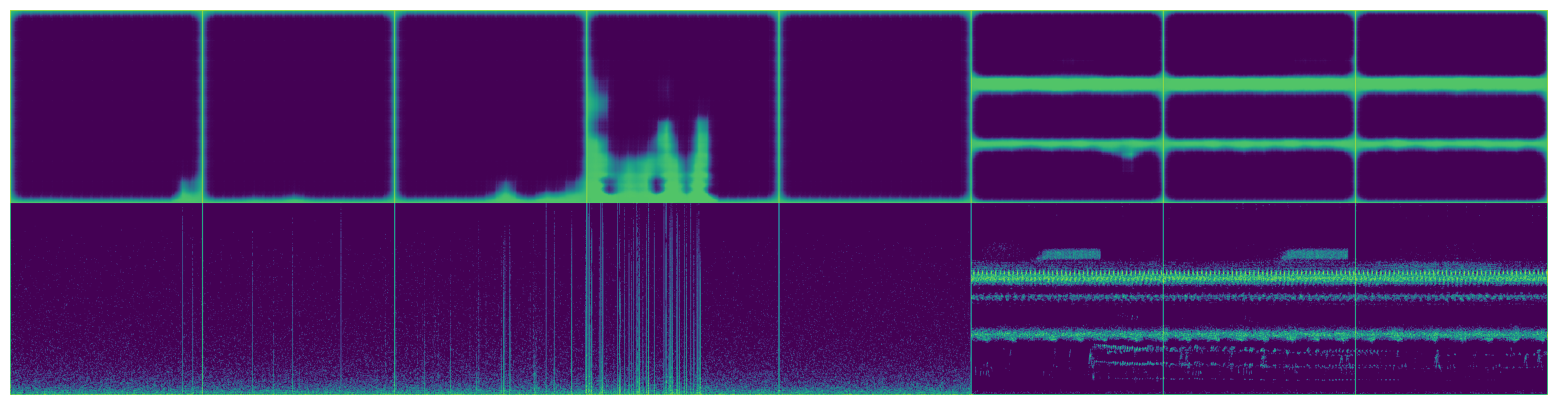

encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 201 of 3189 	 loss: 0.8484
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 202 of 3189 	 loss: 0.8717
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 203 of 3189 	 loss: 0.8713
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 204 of 3189 	 loss: 0.866
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 205 of 3189 	 loss: 0.8613
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 206 of 3189 	 loss: 0.8688
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 207 of

encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 258 of 3189 	 loss: 0.8454
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 259 of 3189 	 loss: 0.8942
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 260 of 3189 	 loss: 0.8728
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 261 of 3189 	 loss: 0.8906
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 262 of 3189 	 loss: 0.888
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 263 of 3189 	 loss: 0.8923
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 264 of

encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 315 of 3189 	 loss: 0.8764
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 316 of 3189 	 loss: 0.8633
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 317 of 3189 	 loss: 0.8561
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 318 of 3189 	 loss: 0.9111
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 319 of 3189 	 loss: 0.8463
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 320 of 3189 	 loss: 0.8947
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 321 o

encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 372 of 3189 	 loss: 0.8544
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 373 of 3189 	 loss: 0.8843
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 374 of 3189 	 loss: 0.8689
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 375 of 3189 	 loss: 0.8874
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 376 of 3189 	 loss: 0.8559
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 377 of 3189 	 loss: 0.8669
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 378 o

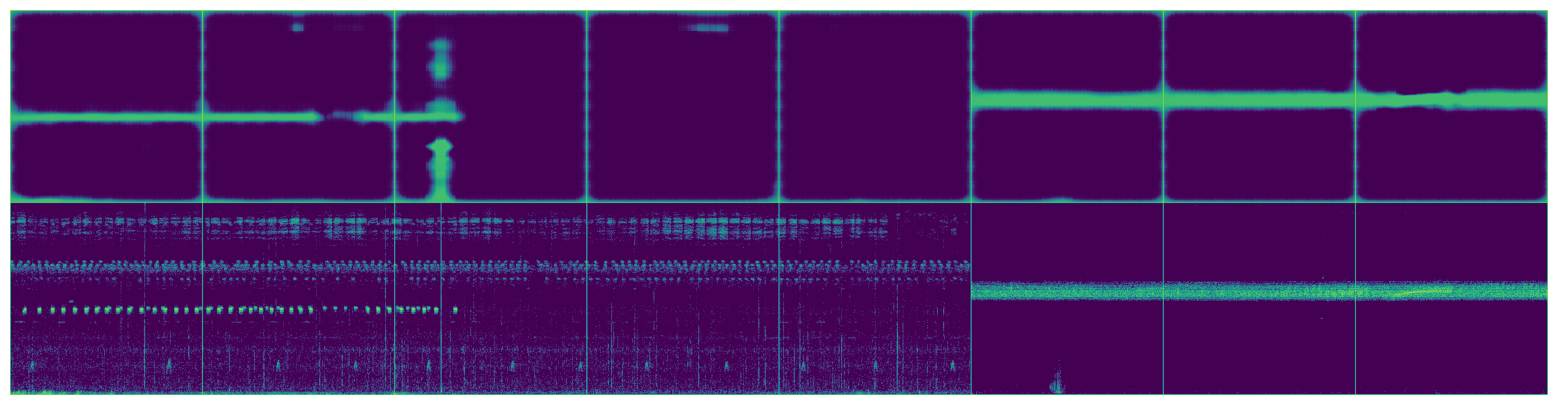

encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 401 of 3189 	 loss: 0.8893
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 402 of 3189 	 loss: 0.8574
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 403 of 3189 	 loss: 0.8899
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 404 of 3189 	 loss: 0.8762
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 405 of 3189 	 loss: 0.9035
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 406 of 3189 	 loss: 0.8853
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 407 o

encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 458 of 3189 	 loss: 0.8673
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 459 of 3189 	 loss: 0.8651
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 460 of 3189 	 loss: 0.8756
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 461 of 3189 	 loss: 0.8601
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 462 of 3189 	 loss: 0.8776
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 463 of 3189 	 loss: 0.8642
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 464 o

encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 515 of 3189 	 loss: 0.8444
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 516 of 3189 	 loss: 0.9
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 517 of 3189 	 loss: 0.8849
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 518 of 3189 	 loss: 0.8467
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 519 of 3189 	 loss: 0.8718
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 520 of 3189 	 loss: 0.8556
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 521 of 3

encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 572 of 3189 	 loss: 0.8446
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 573 of 3189 	 loss: 0.8907
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 574 of 3189 	 loss: 0.8617
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 575 of 3189 	 loss: 0.8781
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 576 of 3189 	 loss: 0.886
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 577 of 3189 	 loss: 0.8726
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 578 of

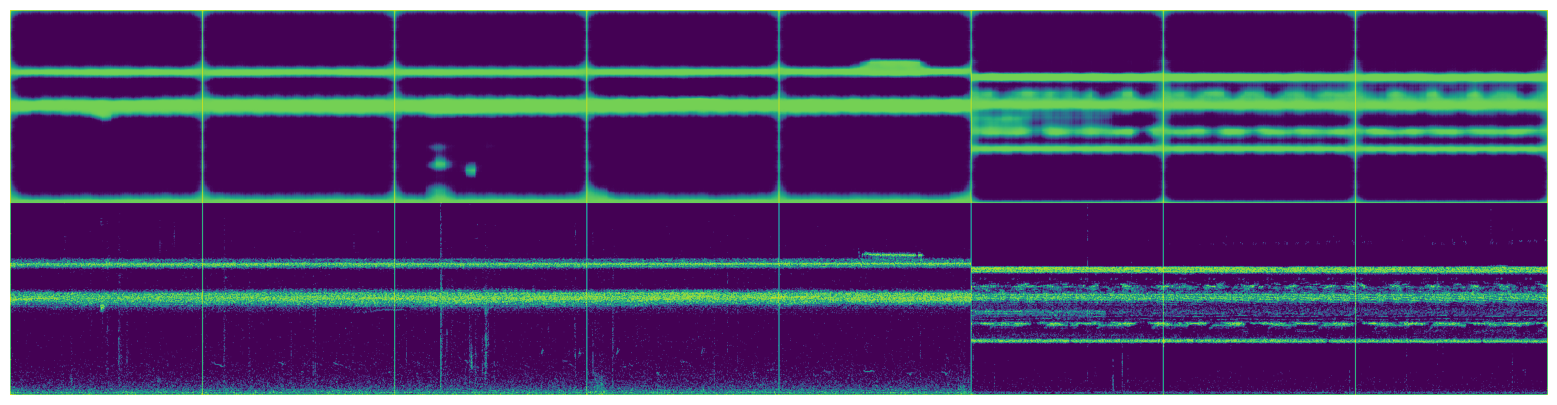

encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 601 of 3189 	 loss: 0.8784
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 602 of 3189 	 loss: 0.8588
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 603 of 3189 	 loss: 0.868
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 604 of 3189 	 loss: 0.8609
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 605 of 3189 	 loss: 0.8794
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 606 of 3189 	 loss: 0.8772
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 607 of

encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 658 of 3189 	 loss: 0.8798
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 659 of 3189 	 loss: 0.8415
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 660 of 3189 	 loss: 0.8603
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 661 of 3189 	 loss: 0.8404
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 662 of 3189 	 loss: 0.8549
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 663 of 3189 	 loss: 0.8551
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 664 o

encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 715 of 3189 	 loss: 0.883
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 716 of 3189 	 loss: 0.8641
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 717 of 3189 	 loss: 0.8726
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 718 of 3189 	 loss: 0.8904
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 719 of 3189 	 loss: 0.8692
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 720 of 3189 	 loss: 0.8768
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 721 of

encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 772 of 3189 	 loss: 0.8958
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 773 of 3189 	 loss: 0.8979
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 774 of 3189 	 loss: 0.8955
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 775 of 3189 	 loss: 0.849
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 776 of 3189 	 loss: 0.8742
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 777 of 3189 	 loss: 0.878
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 778 of 

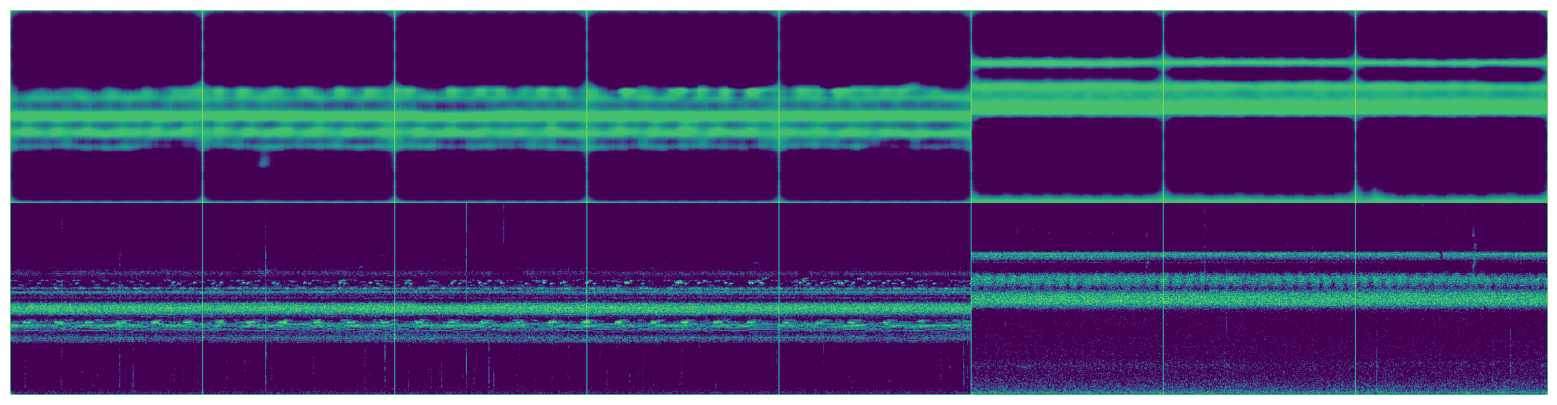

encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 801 of 3189 	 loss: 0.8546
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 802 of 3189 	 loss: 0.8891
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 803 of 3189 	 loss: 0.8688
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 804 of 3189 	 loss: 0.8487
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 805 of 3189 	 loss: 0.9013
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 806 of 3189 	 loss: 0.8787
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 807 o

encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 858 of 3189 	 loss: 0.8734
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 859 of 3189 	 loss: 0.8777
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 860 of 3189 	 loss: 0.8362
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 861 of 3189 	 loss: 0.8806
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 862 of 3189 	 loss: 0.8696
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 863 of 3189 	 loss: 0.8761
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 864 o

encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 915 of 3189 	 loss: 0.8734
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 916 of 3189 	 loss: 0.8858
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 917 of 3189 	 loss: 0.8683
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 918 of 3189 	 loss: 0.8447
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 919 of 3189 	 loss: 0.8691
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 920 of 3189 	 loss: 0.8538
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 921 o

encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 972 of 3189 	 loss: 0.8991
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 973 of 3189 	 loss: 0.855
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 974 of 3189 	 loss: 0.8404
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 975 of 3189 	 loss: 0.8677
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 976 of 3189 	 loss: 0.8686
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 977 of 3189 	 loss: 0.9084
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 978 of

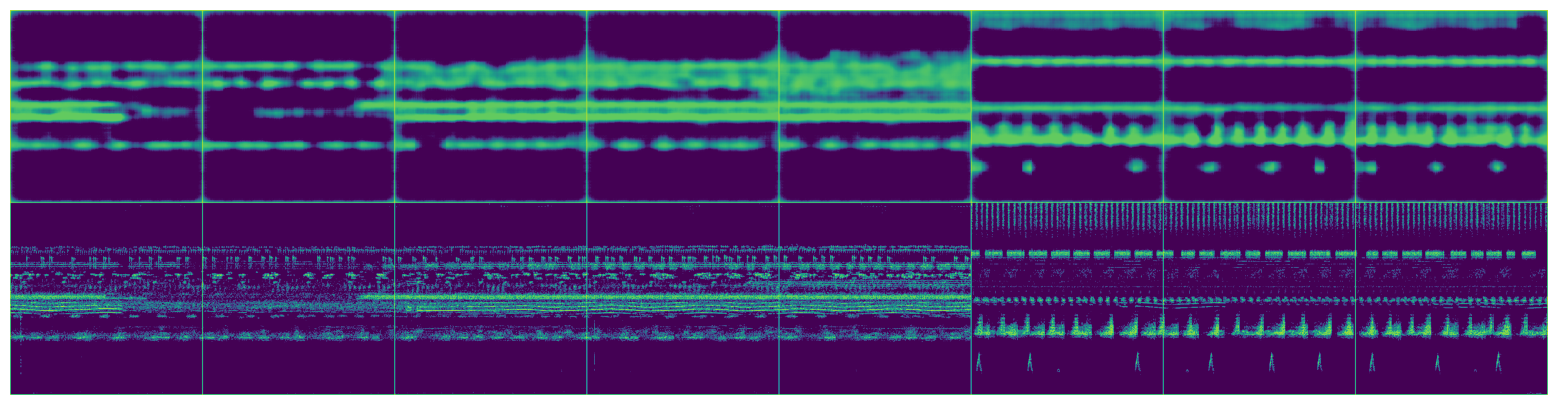

encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1001 of 3189 	 loss: 0.8898
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1002 of 3189 	 loss: 0.8833
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1003 of 3189 	 loss: 0.8422
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1004 of 3189 	 loss: 0.8664
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1005 of 3189 	 loss: 0.8732
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1006 of 3189 	 loss: 0.8426
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration:

encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1057 of 3189 	 loss: 0.8407
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1058 of 3189 	 loss: 0.8775
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1059 of 3189 	 loss: 0.8627
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1060 of 3189 	 loss: 0.8605
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1061 of 3189 	 loss: 0.89
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1062 of 3189 	 loss: 0.9062
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1

encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1113 of 3189 	 loss: 0.8562
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1114 of 3189 	 loss: 0.8666
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1115 of 3189 	 loss: 0.8996
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1116 of 3189 	 loss: 0.8516
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1117 of 3189 	 loss: 0.8713
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1118 of 3189 	 loss: 0.8529
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration:

encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1169 of 3189 	 loss: 0.8632
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1170 of 3189 	 loss: 0.879
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1171 of 3189 	 loss: 0.8687
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1172 of 3189 	 loss: 0.8716
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1173 of 3189 	 loss: 0.9039
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1174 of 3189 	 loss: 0.865
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1

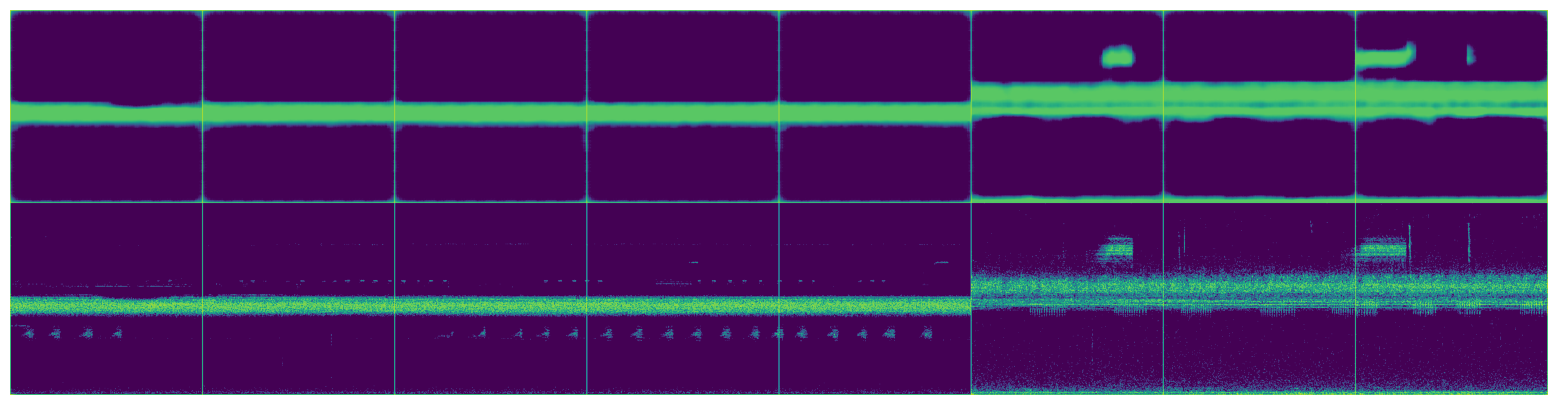

encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1201 of 3189 	 loss: 0.8573
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1202 of 3189 	 loss: 0.8388
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1203 of 3189 	 loss: 0.8766
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1204 of 3189 	 loss: 0.8909
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1205 of 3189 	 loss: 0.8616
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1206 of 3189 	 loss: 0.8971
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration:

encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1257 of 3189 	 loss: 0.8414
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1258 of 3189 	 loss: 0.8465
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1259 of 3189 	 loss: 0.8877
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1260 of 3189 	 loss: 0.8623
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1261 of 3189 	 loss: 0.856
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1262 of 3189 	 loss: 0.8765
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 

encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1313 of 3189 	 loss: 0.8502
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1314 of 3189 	 loss: 0.8644
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1315 of 3189 	 loss: 0.875
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1316 of 3189 	 loss: 0.8735
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1317 of 3189 	 loss: 0.8832
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1318 of 3189 	 loss: 0.8659
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 

encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1369 of 3189 	 loss: 0.8951
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1370 of 3189 	 loss: 0.8811
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1371 of 3189 	 loss: 0.8471
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1372 of 3189 	 loss: 0.8514
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1373 of 3189 	 loss: 0.8792
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1374 of 3189 	 loss: 0.8581
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration:

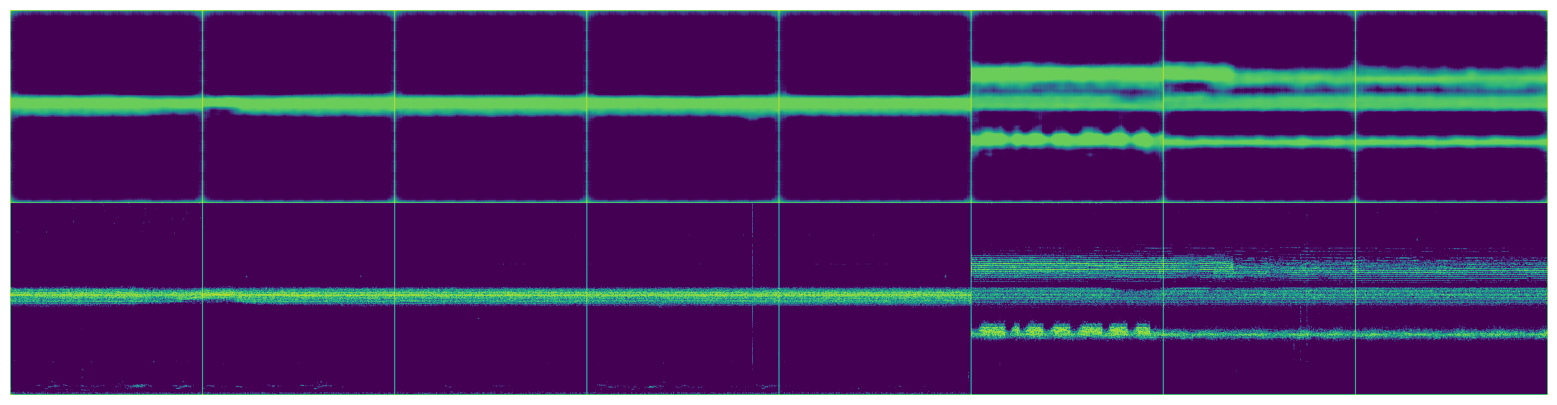

encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1401 of 3189 	 loss: 0.847
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1402 of 3189 	 loss: 0.8601
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1403 of 3189 	 loss: 0.8906
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1404 of 3189 	 loss: 0.8416
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1405 of 3189 	 loss: 0.8572
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1406 of 3189 	 loss: 0.8614
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 

encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1457 of 3189 	 loss: 0.8496
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1458 of 3189 	 loss: 0.8568
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1459 of 3189 	 loss: 0.8367
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1460 of 3189 	 loss: 0.8587
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1461 of 3189 	 loss: 0.8532
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1462 of 3189 	 loss: 0.8648
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration:

encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1513 of 3189 	 loss: 0.8578
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1514 of 3189 	 loss: 0.8454
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1515 of 3189 	 loss: 0.8645
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1516 of 3189 	 loss: 0.8544
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1517 of 3189 	 loss: 0.8522
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1518 of 3189 	 loss: 0.8513
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration:

encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1570 of 3189 	 loss: 0.8573
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1571 of 3189 	 loss: 0.8347
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1572 of 3189 	 loss: 0.8961
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1573 of 3189 	 loss: 0.865
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1574 of 3189 	 loss: 0.8947
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1575 of 3189 	 loss: 0.8427
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 

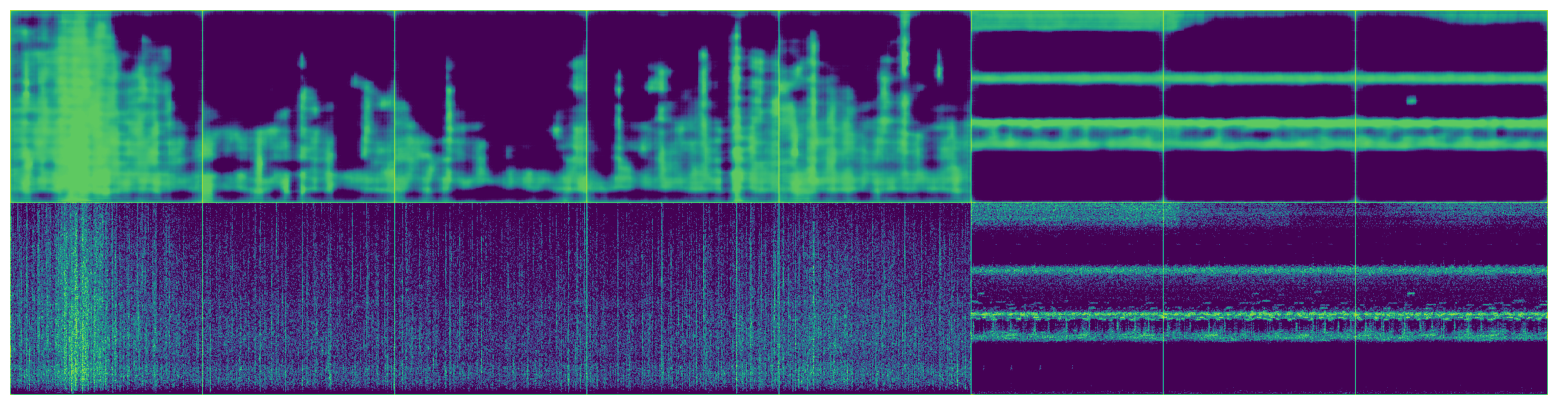

encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1601 of 3189 	 loss: 0.8419
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1602 of 3189 	 loss: 0.8992
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1603 of 3189 	 loss: 0.8856
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1604 of 3189 	 loss: 0.8823
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1605 of 3189 	 loss: 0.9068
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1606 of 3189 	 loss: 0.8426
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration:

encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1657 of 3189 	 loss: 0.9033
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1658 of 3189 	 loss: 0.8788
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1659 of 3189 	 loss: 0.8527
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1660 of 3189 	 loss: 0.8676
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1661 of 3189 	 loss: 0.8563
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1662 of 3189 	 loss: 0.8563
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration:

encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1714 of 3189 	 loss: 0.8944
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1715 of 3189 	 loss: 0.8592
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1716 of 3189 	 loss: 0.8653
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1717 of 3189 	 loss: 0.8206
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1718 of 3189 	 loss: 0.868
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1719 of 3189 	 loss: 0.8578
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 

encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1770 of 3189 	 loss: 0.8562
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1771 of 3189 	 loss: 0.8781
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1772 of 3189 	 loss: 0.8511
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1773 of 3189 	 loss: 0.8564
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1774 of 3189 	 loss: 0.8982
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1775 of 3189 	 loss: 0.8472
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration:

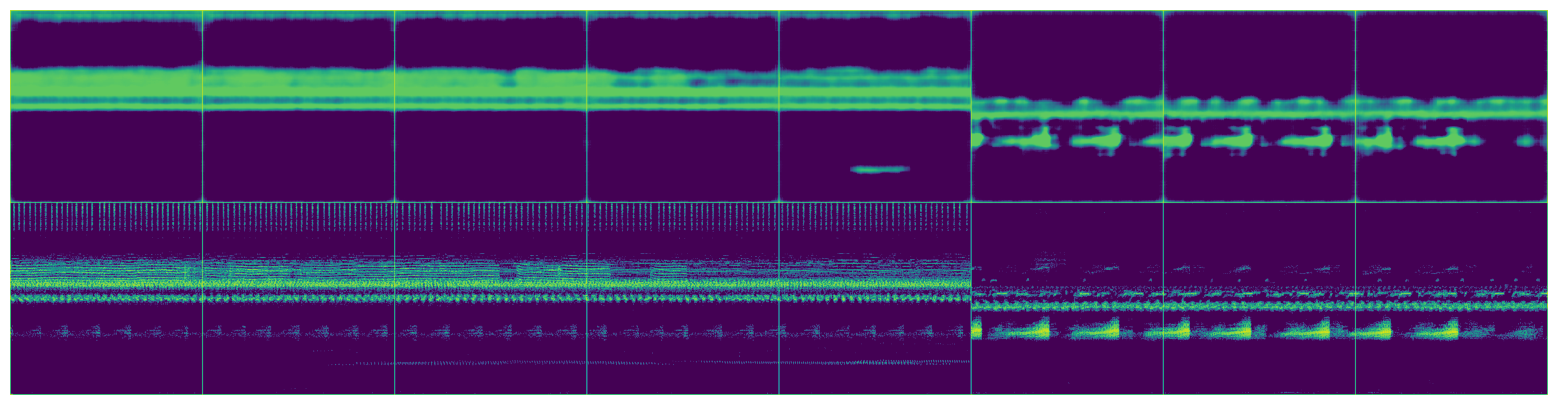

encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1801 of 3189 	 loss: 0.8659
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1802 of 3189 	 loss: 0.8798
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1803 of 3189 	 loss: 0.8735
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1804 of 3189 	 loss: 0.8599
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1805 of 3189 	 loss: 0.8586
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1806 of 3189 	 loss: 0.876
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 

encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1857 of 3189 	 loss: 0.849
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1858 of 3189 	 loss: 0.8872
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1859 of 3189 	 loss: 0.886
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1860 of 3189 	 loss: 0.8869
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1861 of 3189 	 loss: 0.8319
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1862 of 3189 	 loss: 0.8955
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1

encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1913 of 3189 	 loss: 0.8795
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1914 of 3189 	 loss: 0.8772
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1915 of 3189 	 loss: 0.8913
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1916 of 3189 	 loss: 0.8644
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1917 of 3189 	 loss: 0.8575
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1918 of 3189 	 loss: 0.8711
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration:

encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1969 of 3189 	 loss: 0.8699
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1970 of 3189 	 loss: 0.8279
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1971 of 3189 	 loss: 0.8811
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1972 of 3189 	 loss: 0.8497
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1973 of 3189 	 loss: 0.8634
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1974 of 3189 	 loss: 0.8648
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration:

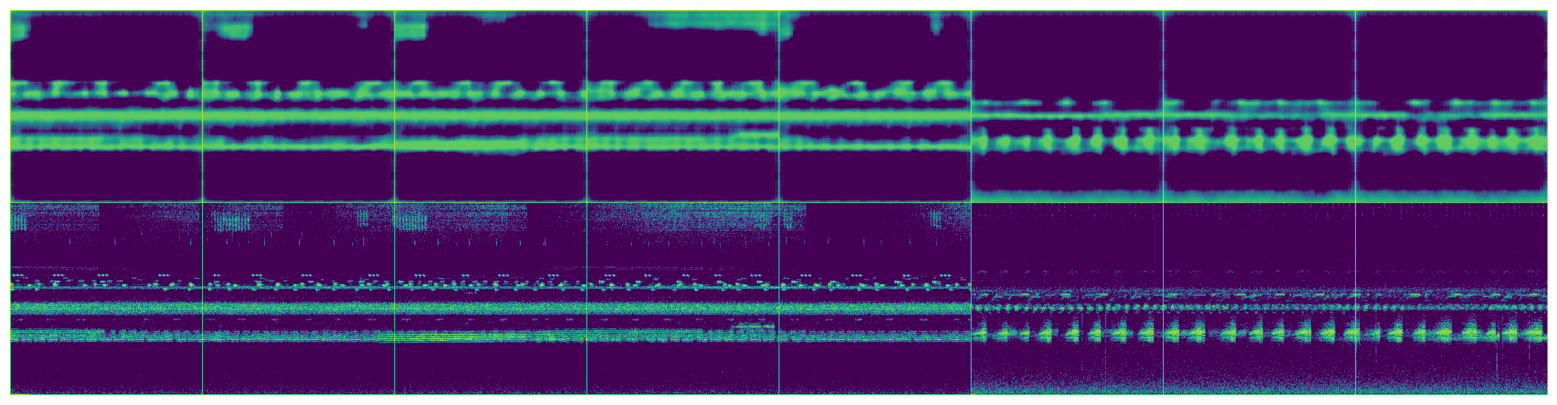

encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2001 of 3189 	 loss: 0.8761
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2002 of 3189 	 loss: 0.8751
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2003 of 3189 	 loss: 0.8764
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2004 of 3189 	 loss: 0.8759
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2005 of 3189 	 loss: 0.8817
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2006 of 3189 	 loss: 0.8462
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration:

encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2057 of 3189 	 loss: 0.8441
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2058 of 3189 	 loss: 0.9049
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2059 of 3189 	 loss: 0.8601
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2060 of 3189 	 loss: 0.8683
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2061 of 3189 	 loss: 0.8577
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2062 of 3189 	 loss: 0.8582
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration:

encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2113 of 3189 	 loss: 0.8787
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2114 of 3189 	 loss: 0.8807
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2115 of 3189 	 loss: 0.871
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2116 of 3189 	 loss: 0.8469
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2117 of 3189 	 loss: 0.8359
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2118 of 3189 	 loss: 0.8783
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 

encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2170 of 3189 	 loss: 0.8591
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2171 of 3189 	 loss: 0.8358
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2172 of 3189 	 loss: 0.8625
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2173 of 3189 	 loss: 0.8734
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2174 of 3189 	 loss: 0.876
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2175 of 3189 	 loss: 0.883
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2

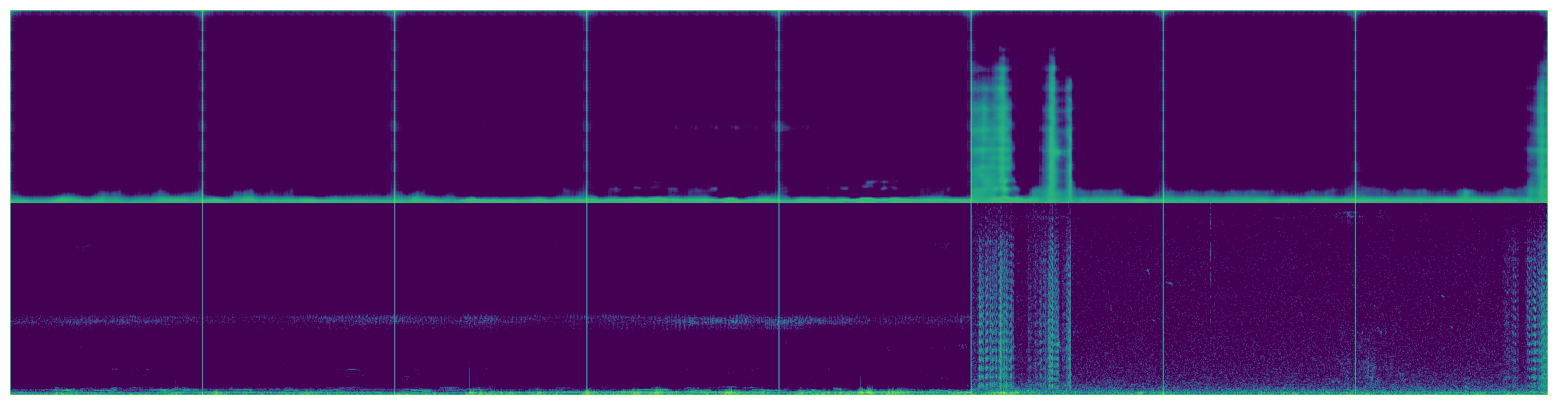

encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2201 of 3189 	 loss: 0.8568
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2202 of 3189 	 loss: 0.8724
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2203 of 3189 	 loss: 0.85
error
Trying to create tensor with negative dimension -199187: [1, -199187]
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2205 of 3189 	 loss: 0.8516
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2206 of 3189 	 loss: 0.8508
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2207 of 3189 	 loss: 0.8566
encoder_shape:  torch.Size([100, 64, 9, 9])


encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2258 of 3189 	 loss: 0.8584
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2259 of 3189 	 loss: 0.8382
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2260 of 3189 	 loss: 0.8593
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2261 of 3189 	 loss: 0.8492
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2262 of 3189 	 loss: 0.8259
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2263 of 3189 	 loss: 0.8347
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration:

encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2314 of 3189 	 loss: 0.8685
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2315 of 3189 	 loss: 0.8704
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2316 of 3189 	 loss: 0.888
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2317 of 3189 	 loss: 0.869
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2318 of 3189 	 loss: 0.8834
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2319 of 3189 	 loss: 0.8787
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2

encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2370 of 3189 	 loss: 0.8696
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2371 of 3189 	 loss: 0.8749
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2372 of 3189 	 loss: 0.8885
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2373 of 3189 	 loss: 0.8758
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2374 of 3189 	 loss: 0.8581
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2375 of 3189 	 loss: 0.8563
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration:

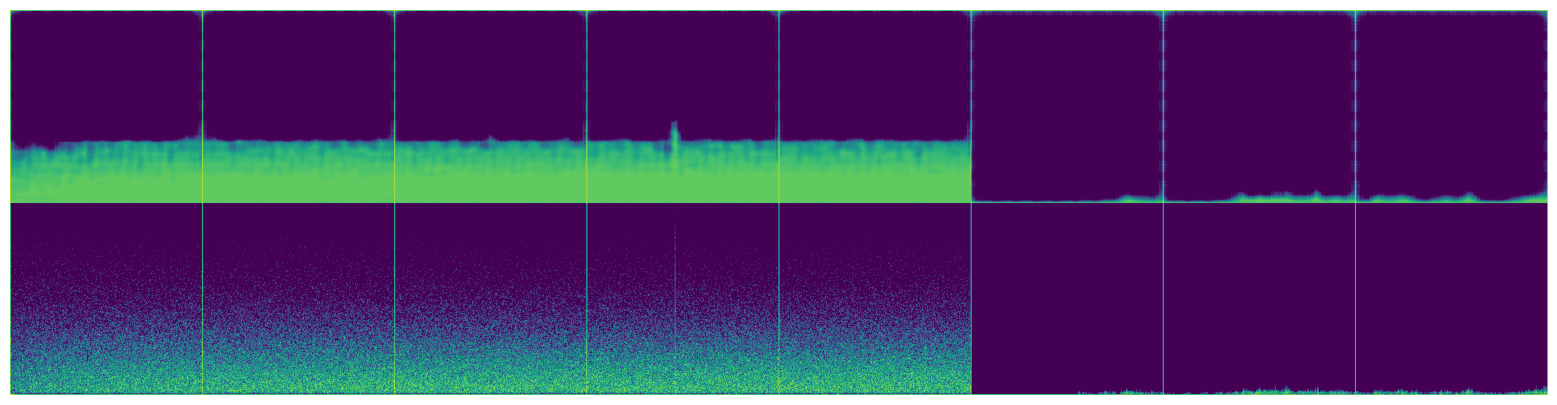

encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2401 of 3189 	 loss: 0.8798
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2402 of 3189 	 loss: 0.849
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2403 of 3189 	 loss: 0.8767
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2404 of 3189 	 loss: 0.8663
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2405 of 3189 	 loss: 0.8779
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2406 of 3189 	 loss: 0.84
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 24

encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2457 of 3189 	 loss: 0.8575
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2458 of 3189 	 loss: 0.8441
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2459 of 3189 	 loss: 0.871
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2460 of 3189 	 loss: 0.8582
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2461 of 3189 	 loss: 0.8895
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2462 of 3189 	 loss: 0.8607
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 

encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2513 of 3189 	 loss: 0.8281
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2514 of 3189 	 loss: 0.871
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2515 of 3189 	 loss: 0.8901
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2516 of 3189 	 loss: 0.8599
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2517 of 3189 	 loss: 0.8668
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2518 of 3189 	 loss: 0.8616
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 

encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2569 of 3189 	 loss: 0.8562
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2570 of 3189 	 loss: 0.8424
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2571 of 3189 	 loss: 0.8446
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2572 of 3189 	 loss: 0.8518
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2573 of 3189 	 loss: 0.8675
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2574 of 3189 	 loss: 0.8856
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration:

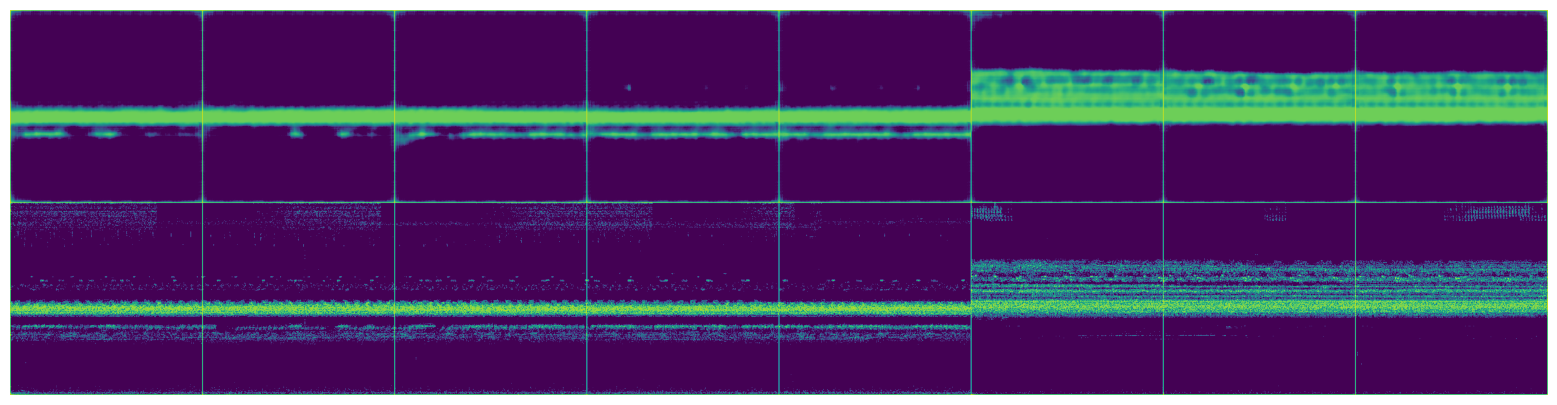

encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2601 of 3189 	 loss: 0.8819
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2602 of 3189 	 loss: 0.8563
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2603 of 3189 	 loss: 0.864
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2604 of 3189 	 loss: 0.8527
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2605 of 3189 	 loss: 0.8664
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2606 of 3189 	 loss: 0.856
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2

encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2657 of 3189 	 loss: 0.8502
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2658 of 3189 	 loss: 0.868
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2659 of 3189 	 loss: 0.8358
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2660 of 3189 	 loss: 0.8801
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2661 of 3189 	 loss: 0.8785
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2662 of 3189 	 loss: 0.843
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2

encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2713 of 3189 	 loss: 0.8344
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2714 of 3189 	 loss: 0.8499
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2715 of 3189 	 loss: 0.8708
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2716 of 3189 	 loss: 0.8955
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2717 of 3189 	 loss: 0.9126
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2718 of 3189 	 loss: 0.8644
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration:

encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2769 of 3189 	 loss: 0.8626
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2770 of 3189 	 loss: 0.8695
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2771 of 3189 	 loss: 0.8947
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2772 of 3189 	 loss: 0.8442
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2773 of 3189 	 loss: 0.8825
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2774 of 3189 	 loss: 0.8192
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration:

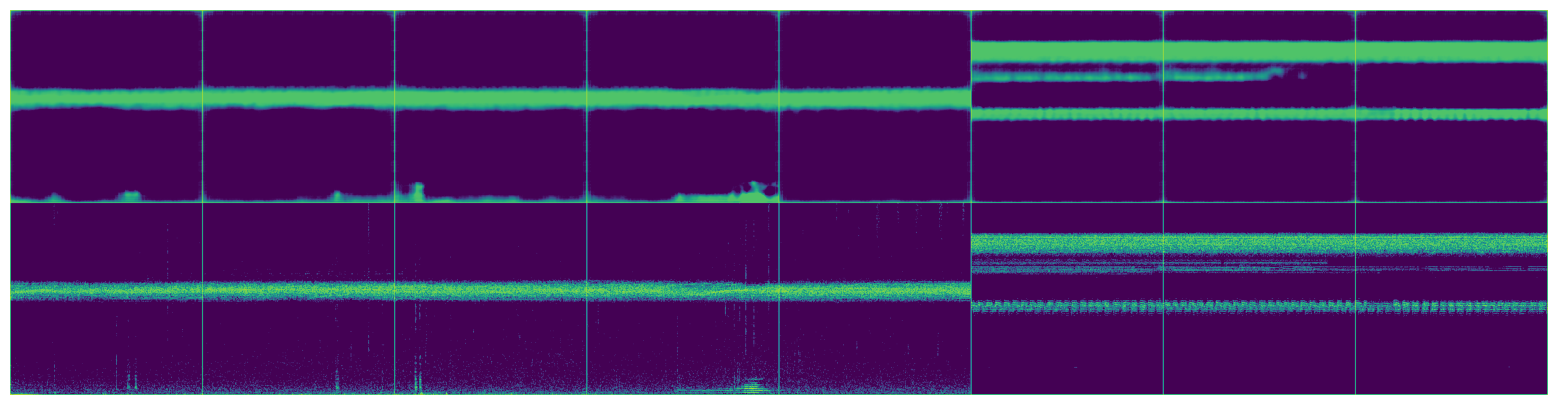

encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2801 of 3189 	 loss: 0.8469
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2802 of 3189 	 loss: 0.8901
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2803 of 3189 	 loss: 0.8687
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2804 of 3189 	 loss: 0.8511
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2805 of 3189 	 loss: 0.8372
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2806 of 3189 	 loss: 0.8457
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration:

encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2857 of 3189 	 loss: 0.8637
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2858 of 3189 	 loss: 0.8601
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2859 of 3189 	 loss: 0.8605
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2860 of 3189 	 loss: 0.8467
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2861 of 3189 	 loss: 0.8323
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2862 of 3189 	 loss: 0.8578
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration:

encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2913 of 3189 	 loss: 0.8523
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2914 of 3189 	 loss: 0.8624
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2915 of 3189 	 loss: 0.8641
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2916 of 3189 	 loss: 0.8862
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2917 of 3189 	 loss: 0.8431
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2918 of 3189 	 loss: 0.8772
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration:

encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2969 of 3189 	 loss: 0.873
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2970 of 3189 	 loss: 0.8362
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2971 of 3189 	 loss: 0.8265
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2972 of 3189 	 loss: 0.858
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2973 of 3189 	 loss: 0.8421
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2974 of 3189 	 loss: 0.8848
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2

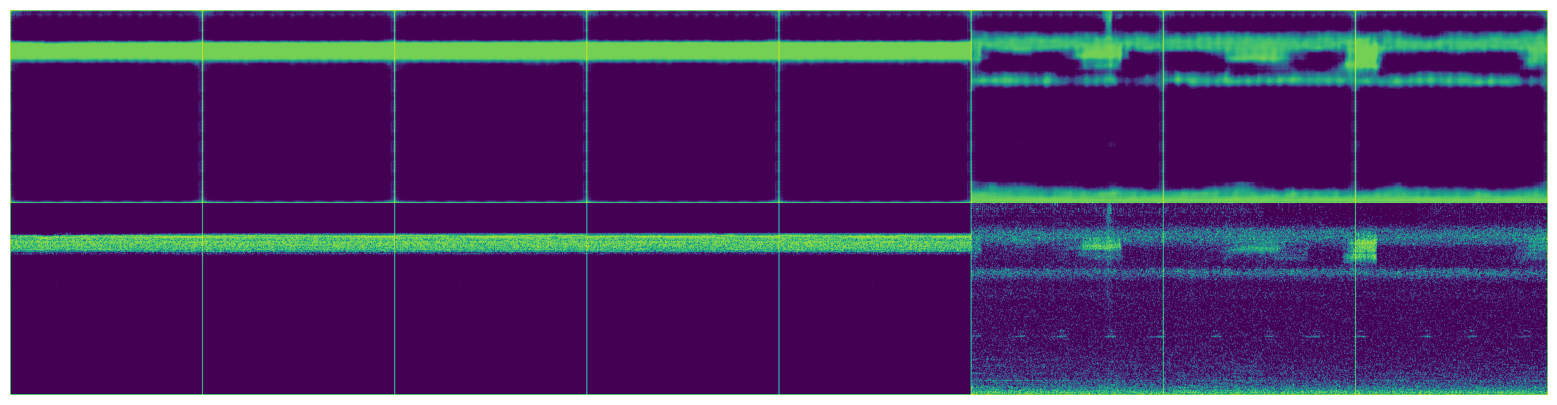

encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 3001 of 3189 	 loss: 0.8908
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 3002 of 3189 	 loss: 0.8798
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 3003 of 3189 	 loss: 0.8748
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 3004 of 3189 	 loss: 0.8213
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 3005 of 3189 	 loss: 0.8599
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 3006 of 3189 	 loss: 0.8824
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration:

encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 3057 of 3189 	 loss: 0.8482
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 3058 of 3189 	 loss: 0.8695
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 3059 of 3189 	 loss: 0.8705
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 3060 of 3189 	 loss: 0.9167
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 3061 of 3189 	 loss: 0.8832
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 3062 of 3189 	 loss: 0.8804
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration:

encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 3113 of 3189 	 loss: 0.872
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 3114 of 3189 	 loss: 0.8444
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 3115 of 3189 	 loss: 0.8365
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 3116 of 3189 	 loss: 0.8648
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 3117 of 3189 	 loss: 0.8535
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 3118 of 3189 	 loss: 0.8642
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 

encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 3170 of 3189 	 loss: 0.8225
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 3171 of 3189 	 loss: 0.8523
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 3172 of 3189 	 loss: 0.864
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 3173 of 3189 	 loss: 0.8698
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 3174 of 3189 	 loss: 0.8322
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 3175 of 3189 	 loss: 0.8374
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 

RuntimeError: Parent directory temporal/models does not exist.

In [4]:
Training = TrainModel(model)
model, logs, run_name = Training.fordward(training_loader, test_loader, config)
time = datetime.datetime.now()
torch.save(model.state_dict(),f'temporal_zamuro/models/model_{run_name}_day_{time.day}_hour_{time.hour}_final.pth')
torch.save(config,f'temporal_zamuro/configs/config_{run_name}_day_{time.day}_hour_{time.hour}.pth')
torch.save(dataset_test, f"temporal_zamuro/datasets/dataset_test_ae_zamuro_{time.day}_70%.pth")
torch.save(dataset_train, f"temporal_zamuro/datasets/dataset_train_ae_zamuro_{time.day}_70%.pth")

In [ ]:
dataset_test = torch.load(f'temporal/dataset_test_ae_jaguas')
dataset_train = torch.load(f'temporal/dataset_train_ae_jaguas')
model.load_state_dict(torch.load(f'temporal/models/model_{run_name}_day_{time.day}_hour_{time.hour}_final.pth', map_location=torch.device('cpu')))

In [ ]:
# root_path = '/content/drive/Shareddrives/ConservacionBiologicaIA/Datos/Porce_2019'


# dataset = SoundscapeData(root_path, audio_length=12, ext="WAV", win_length=1028)
# dataset_train, dataset_test = random_split(dataset,
#                                            [round(len(dataset)*0.7), len(dataset) - round(len(dataset)*0.7)], 
#                                            generator=torch.Generator().manual_seed(1024))
# Dataset_train = DataLoader(dataset_train, batch_size=54, shuffle=True)
# Dataset = DataLoader(dataset_test, batch_size=54, shuffle=True)

training_loader = DataLoader(dataset_train, batch_size=100)
test_loader = DataLoader(dataset_test, batch_size=100)
iterator = iter(test_loader)
testing = TestModel(model, iterator, device=torch.device("cuda"))


In [ ]:
originals, reconstructions, encodings, label, loss= testing.run()

In [ ]:
wav_origin=testing.waveform_generator(spec=originals)
print(wav_origin[0:1])
wav_origin = np.interp(wav_origin, (wav_origin.min(), wav_origin.max()), (-1, +1))
print(wav_origin[0:1])
wav_recons=testing.waveform_generator(spec=reconstructions)
wav_recons= np.interp(wav_recons, (wav_recons.min(), wav_recons.max()), (-1, +1))
testing.plot_psd(wav_origin[0:4],2)
testing.plot_psd(wav_origin[10:14],2)
#testing.plot_psd(wav_origin[18:22],2)
plt.savefig("original_psd.pdf")
plt.figure()
testing.plot_psd(wav_recons[0:4],2)
testing.plot_psd(wav_recons[10:14],2)
#testing.plot_psd(wav_recons[18:22],2)
plt.savefig("recon_psd.pdf")
wav_diff = wav_origin-wav_recons
plt.figure()
testing.plot_psd(wav_diff,4)

In [ ]:
wav_origin=testing.waveform_generator(spec=originals)
print(wav_origin[0:1])
wav_origin = np.interp(wav_origin, (wav_origin.min(), wav_origin.max()), (-1, +1))
print(wav_origin[0:1])
wav_recons=testing.waveform_generator(spec=reconstructions)
wav_recons= np.interp(wav_recons, (wav_recons.min(), wav_recons.max()), (-1, +1))
testing.plot_psd(wav_origin,2)
plt.savefig("original_psd.pdf")
plt.figure()
testing.plot_psd(wav_recons,2)
plt.savefig("recon_psd.pdf")
wav_diff = wav_origin-wav_recons
plt.figure()
testing.plot_psd(wav_diff,4)


In [ ]:
plt.plot(wav_origin[12,0])
plt.plot(wav_recons[12,0], color='red', alpha = 0.4)

In [ ]:
# encodings_size = [64,9,9]
# plt.figure(figsize=(18, 18))
# model.to("cpu")
# for i, spec in enumerate(kmeans.cluster_centers_):
#     encodings = spec.reshape(encodings_size)
#     encodings = torch.tensor(encodings).float()
#     decodings = model.decoder(encodings).detach().numpy()
#     plt.subplot(9, 9, i + 1)
#     plt.imshow(decodings[0,:,:], cmap="inferno", interpolation="nearest",vmin=0, vmax=0.02)
#     plt.xticks(())
#     plt.yticks(())
